# Scratch Notebook: HMS-HBA Spectrogram files
* Exploratory notebook to investigate spectrogram files
* Use pandas to read in parquet format
* Make a cleaner notebook later to save spectrograms as images for training


# Install libraries

# Import libraries

In [118]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scienceplots
plt.style.use(['science','no-latex'])

import warnings
warnings.filterwarnings("ignore")

# Load data

In [4]:
kaggle = False
root_dir = '.'
if kaggle:
    root_dir = '/kaggle/input/hms-harmful-brain-activity-classification'

train = pd.read_csv(root_dir + '/train.csv')
test = pd.read_csv(root_dir + '/test.csv')
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# set path variables
train_eegs = root_dir + '/train_eegs'
train_spectrograms = root_dir + '/train_spectrograms'


# Top level Stats

In [5]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}')
display(train.head())
print(f'Test Data Shape: {test.shape}')
display(test.head())
print(f'Sample Submission Shape: {ss.shape}')
display(ss.head())

Training Data Shape: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


Test Data Shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Sample Submission Shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


## Target Variable

In [6]:
targets = [col for col in train.columns if '_vote' in col]
print(targets)

['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


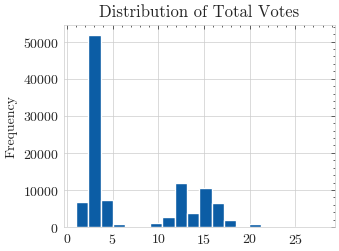

In [7]:
# create a total vote column which is the sum of all the target votes
train['total_votes'] = train[targets].sum(axis=1)
train.total_votes.plot(kind='hist',bins=20)
plt.title('Distribution of Total Votes');

In [8]:
# divide all the targets by the total votes to get a normalized vote
for target in targets:
    train[target] = train[target] / train['total_votes']
train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3


# Groupby spectrogram_id and keep only first row
* later will use the individual spectrogram sub_id's


In [9]:
# groupby spectrogram_id and keep only first row
train_unique = train.groupby('spectrogram_id').first().reset_index()
train_unique.head()

,spectrogram_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_votes
0,353733,1628180742,0,0.0,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3
1,924234,2277392603,0,0.0,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,11
2,999431,722738444,0,0.0,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,16
3,1084844,387987538,0,0.0,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,3
4,1219001,2175806584,0,0.0,0,0.0,1963161945,23435,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,3


In [10]:
len(train_unique)

11138

In [29]:
# use glob to make a list of files in the spectrogram directory and verify same number
spectrograms = glob.glob(train_spectrograms + '/*.parquet')
len(spectrograms) == len(train_unique)


True

# Drop total_votes column

In [12]:
# drop total_votes column from train_unique
train_unique.drop('total_votes',axis=1,inplace=True)

# Open a spectrogram file


In [32]:
# open the first spectrogram file
spect1 = pd.read_parquet(spectrograms[0])
print(f'Spectrogram shape: {spect1.shape}')
spect1.head()

Spectrogram shape: (303, 401)


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,LL_4.1,LL_4.3,LL_4.49,LL_4.69,LL_4.88,LL_5.08,...,RP_15.23,RP_15.43,RP_15.63,RP_15.82,RP_16.02,RP_16.21,RP_16.41,RP_16.6,RP_16.8,RP_16.99,RP_17.19,RP_17.38,RP_17.58,RP_17.77,RP_17.97,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,5.390000,10.440000,10.29,12.180000,10.41,5.68,7.41,7.19,6.11,7.40,4.41,3.87,3.14,2.36,2.21,2.04,1.61,1.23,1.49,1.33,1.33,1.23,0.52,0.70,...,0.17,0.19,0.18,0.22,0.30,0.34,0.28,0.27,0.21,0.14,0.11,0.11,0.11,0.12,0.16,0.15,0.14,0.15,0.11,0.12,0.23,0.32,0.28,0.31,0.26
1,3,11.600000,12.680000,15.70,14.700000,6.73,8.08,5.48,5.56,4.89,2.71,2.53,1.94,2.00,1.92,1.42,1.06,0.98,0.68,0.46,0.50,0.51,0.35,0.37,0.25,...,0.26,0.26,0.42,0.38,0.39,0.61,0.55,0.53,0.52,0.34,0.14,0.15,0.18,0.22,0.26,0.30,0.18,0.13,0.11,0.13,0.11,0.14,0.15,0.08,0.11
2,5,16.940001,18.510000,20.15,15.470000,8.15,6.90,4.28,5.08,3.90,3.08,2.83,1.69,1.35,1.25,1.08,0.83,0.66,0.56,0.39,0.39,0.37,0.48,0.27,0.33,...,0.25,0.31,0.31,0.20,0.26,0.30,0.34,0.42,0.47,0.28,0.23,0.19,0.12,0.27,0.23,0.28,0.26,0.15,0.15,0.12,0.13,0.13,0.12,0.10,0.11
3,7,12.800000,17.450001,17.24,13.750000,15.26,12.70,13.33,11.31,7.10,5.84,2.24,2.68,1.77,1.71,1.86,1.13,1.11,1.38,1.33,1.23,1.05,0.85,0.62,0.54,...,0.22,0.16,0.11,0.18,0.13,0.15,0.13,0.17,0.19,0.12,0.24,0.18,0.18,0.31,0.18,0.37,0.35,0.21,0.34,0.23,0.19,0.18,0.12,0.10,0.15
4,9,12.890000,21.070000,23.57,22.290001,19.98,12.38,10.68,10.37,8.74,3.39,3.12,1.80,1.24,2.20,1.38,1.30,1.96,1.46,1.72,1.60,0.96,1.03,1.19,0.78,...,0.28,0.31,0.26,0.27,0.23,0.21,0.26,0.22,0.24,0.28,0.23,0.15,0.14,0.24,0.20,0.25,0.26,0.18,0.12,0.13,0.11,0.11,0.14,0.15,0.17


## Convert to 2d numpy array, normalize between 0 and 1, and plot

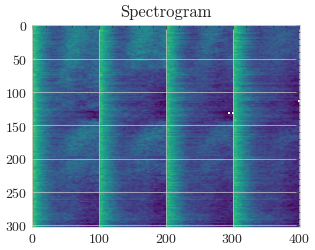

In [35]:
spectrogram = df.values / df.values.max()
plt.imshow(np.log(spectrogram),cmap='viridis')
plt.title('Spectrogram');

In [34]:
# how many columns have 'LL', 'LR', etc. in them?
print(f'LL cols: {len([col for col in spect1.columns if "LL" in col])}')
print(f'LP cols: {len([col for col in spect1.columns if "LP" in col])}')
print(f'RL cols: {len([col for col in spect1.columns if "RL" in col])}')
print(f'RP cols: {len([col for col in spect1.columns if "LP" in col])}')

LL cols: 100
LP cols: 100
RL cols: 100
RP cols: 100


### Takeaways
* Have 1 time column and 100 columns each for LL, LP, RL, RP
* Try both training on single image and splitting into 4 separate images

In [95]:
# create a new subdirectory called /spectrograms if it doesn't exist
if not os.path.exists('./spectrograms'):
    os.mkdir('./spectrograms')


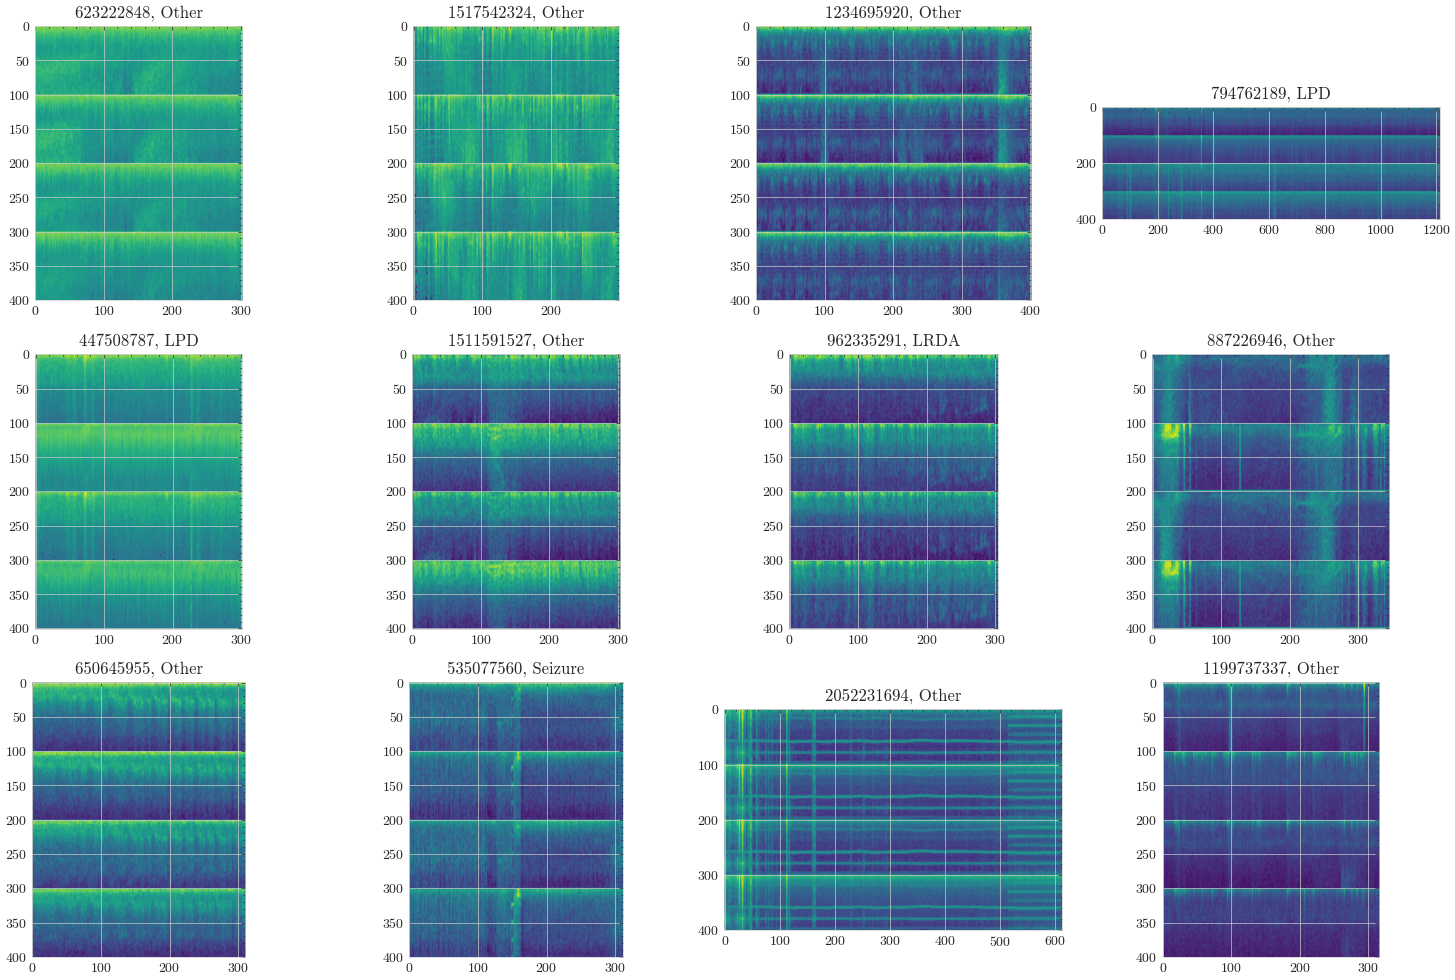

In [343]:
# loop throuth first 12 spectrograms and plot
fig,ax = plt.subplots(3,4,figsize=(15,10))
ax = ax.flatten()
for i in range(12):
    df = pd.read_parquet(spectrograms[i])
    # get the name of the spectrogram file
    spect_id = int(spectrograms[i].split('/')[-1].split('.')[0])
    consensus = train_unique[train_unique.spectrogram_id == spect_id].expert_consensus.values[0]
    # normalize the spectrogram between 0 and 1
    spectrogram = df.values / df.values.max()
    # swap x and y axis
    spectrogram = spectrogram.T
    # replace 0 values with 10e-9
    spectrogram = np.where(spectrogram == 0, 10e-9,spectrogram)
    # take the log of the spectrogram
    spectrogram = np.log(spectrogram)
    # make minimum value 0
    spectrogram = spectrogram + np.abs(np.min(spectrogram))
    # scale the spectrogram to have a max of 255
    spectrogram = 255 * (spectrogram / spectrogram.max())
    # convert to uint8
    spectrogram = spectrogram.astype(np.uint8)
    # save the spectrogram as a png file in the folder /spectrograms
    #plt.imsave(f'spectrograms/{spect_id}.png',spectrogram,cmap='viridis')
    cv2.imwrite(f'spectrograms/{spect_id}.png',spectrogram)
    ax[i].imshow(spectrogram,cmap='viridis')
    ax[i].set_title(f"{spectrograms[i].split('/')[-1].split('.')[0]}, {consensus}")
plt.tight_layout();


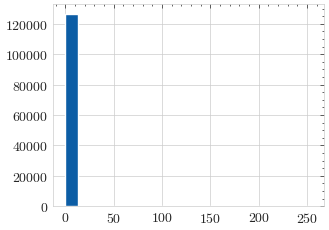

In [314]:
np.max(s)
plt.hist(s.flatten(),bins=20);


In [313]:
# # scale s to have a max of 255
# s = s / s.max()
# s = s * 255
# #s = s.astype(np.uint8)
# plt.imshow(s)


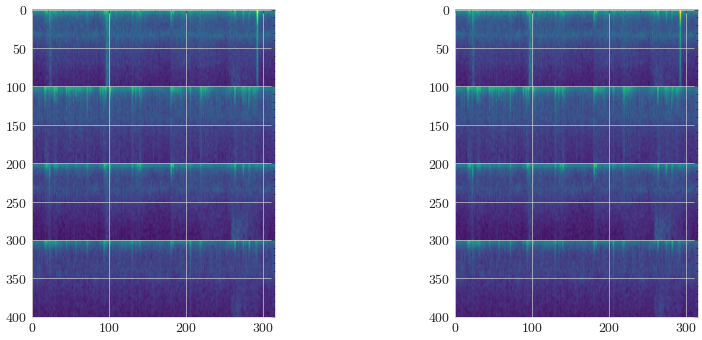

In [315]:
log_spect = np.log(s)
log_spect 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(log_spect,cmap='viridis')
plt.subplot(1,2,2)
plt.imshow(np.log(spectrogram),cmap='viridis');



max, min of df: 362478.375, 0.0
max, min of df: 1.0, 0.0
max, min of df: 1.0, 1e-08
max, min of df: 0.0, -18.420680743952367
max, min of df: 255, 0


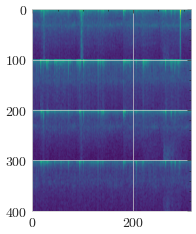

In [338]:
# define process

print(f'max, min of df: {df.values.max()}, {df.values.min()}')
# normalize the values of df between 0 and 1
spectrogram = df.values / df.values.max()
print(f'max, min of df: {spectrogram.max()}, {spectrogram.min()}')

spectrogram = spectrogram.T
# replace 0 values with 10e-9
spectrogram = np.where(spectrogram == 0, 10e-9,spectrogram)
print(f'max, min of df: {spectrogram.max()}, {spectrogram.min()}')

# scale the spectrogram to have a max of 255
#spectrogram = 255 * (spectrogram / spectrogram.max())

# take the log of the spectrogram
spectrogram = np.log(spectrogram)
print(f'max, min of df: {spectrogram.max()}, {spectrogram.min()}')

spectrogram = spectrogram + np.abs(np.min(spectrogram))
spectrogram = 255 * (spectrogram / spectrogram.max())
# convert to uint8
spectrogram = spectrogram.astype(np.uint8)

print(f'max, min of df: {spectrogram.max()}, {spectrogram.min()}')

plt.imshow(spectrogram,cmap='viridis')

In [321]:
np.min(log_spect)
np.max(log_spect)

18.420680743952367

In [316]:
#type(log_spect[0][0])
log_spect = log_spect + np.abs(np.min(log_spect))
np.min(log_spect)

0.0

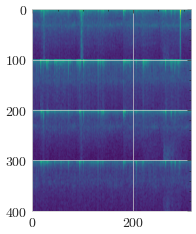

In [302]:
np.max(log_spect)
# scale log_spect to have a max of 255
log_spect = log_spect / log_spect.max()
log_spect = log_spect * 255
log_spect = log_spect.astype(np.uint8)
plt.imshow(log_spect,cmap='viridis')


In [304]:
s[290:300,80:90]

array([[7.03490227e-06, 1.40698045e-05, 1.40698045e-05, 1.40698045e-05,
        1.40698045e-05, 7.03490227e-06, 7.03490227e-06, 7.03490227e-06,
        7.03490227e-06, 7.03490227e-06],
       [7.03490227e-06, 1.40698045e-05, 2.11047068e-05, 1.40698045e-05,
        1.40698045e-05, 7.03490227e-06, 7.03490227e-06, 7.03490227e-06,
        7.03490227e-06, 7.03490227e-06],
       [7.03490227e-06, 1.40698045e-05, 2.11047068e-05, 1.40698045e-05,
        1.40698045e-05, 7.03490227e-06, 7.03490227e-06, 7.03490227e-06,
        7.03490227e-06, 1.40698045e-05],
       [7.03490227e-06, 7.03490227e-06, 1.40698045e-05, 1.40698045e-05,
        7.03490227e-06, 7.03490227e-06, 7.03490227e-06, 7.03490227e-06,
        7.03490227e-06, 1.40698045e-05],
       [1.40698045e-05, 1.40698045e-05, 1.40698045e-05, 1.40698045e-05,
        7.03490227e-06, 7.03490227e-06, 7.03490227e-06, 7.03490227e-06,
        7.03490227e-06, 1.40698045e-05],
       [1.40698045e-05, 1.40698045e-05, 2.11047068e-05, 1.40698045e-05,
   

In [305]:
np.max(s)

255.0

In [306]:
print(f'min, max = {spectrogram.min()}, {spectrogram.max():.3f}')

#find the index of the max value in the spectrogram
max_index = np.where(spectrogram == spectrogram.max())
print(f'index of max value: {max_index}')

# are there any nan values?
print(f'number of nan values: {np.isnan(spectrogram).sum()}')

# are there any inf values?
print(f'number of inf values: {np.isinf(spectrogram).sum()}')



min, max = 0.0, 1.000
index of max value: (array([2]), array([293]))
number of nan values: 0
number of inf values: 0


True

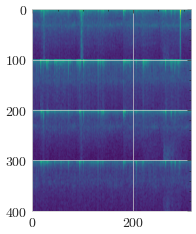

In [308]:

plt.imshow(log_spect,cmap='viridis')

cv2.imwrite('spectrogram_log.jpg',log_spect)

## Solved: Problem is we have some outliers (speckle) that are throwing off the color scale
* Option 1: Remove outliers with stdev
* Option 2: Image filtering to remove "salt and pepper" noise
* Option 3: Use log scale (can be used additionaly with options 1 or 2)

Actually, it was zero values turning into -inf when taking log.  
* Replaced 0 with 10e-9 and it works
* Still taking logs before saving images

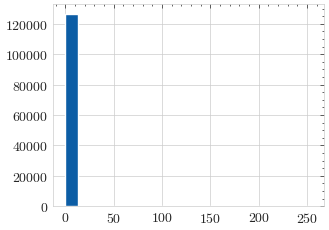

In [147]:
# get a histogram of the spectrogram
plt.hist(spectrogram.flatten(),bins=20);


In [ ]:
# remove outliers with stdev
spectrogram = df.values / df.values.max()
spectrogram = spectrogram.T
spectrogram = np.where(spectrogram > spectrogram.std()*3,spectrogram.std()*3,spectrogram)


## These are different lenghts, so need to split or crop or something
* Look at distribution of lengths

In [85]:
%%time
# loop through all spectrograms and get length
lengths = []
for i in range(len(spectrograms)):
    df = pd.read_parquet(spectrograms[i])
    fname = spectrograms[i].split('/')[-1].split('.')[0]
    lengths.append([fname,df.shape[0]])
        


CPU times: user 3min 7s, sys: 43.4 s, total: 3min 50s
Wall time: 1min 49s


In [310]:
lengths[0:5]

[['764146759', 9116],
 ['1863712617', 6750],
 ['2060670605', 5742],
 ['1908433744', 5281],
 ['1343094925', 4894]]

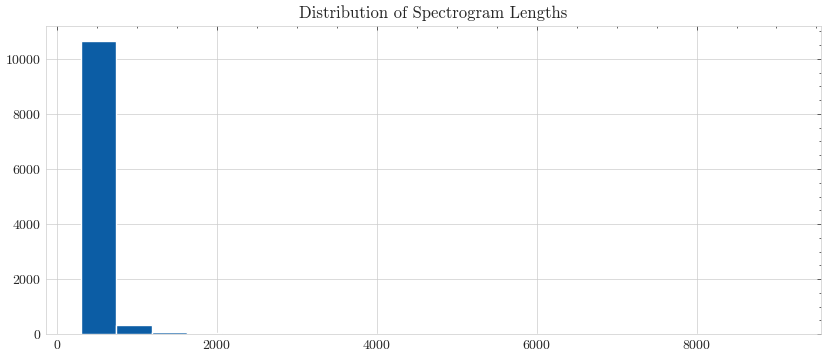

In [311]:
# make a histogram of the lengths
plt.figure(figsize=(10,4))
lengths = [length[1] for length in lengths]
plt.hist(lengths,bins=20)
plt.title('Distribution of Spectrogram Lengths');



In [89]:
# sort lengths by the second column in descending order
lengths.sort(key=lambda x: x[1],reverse=True)
lengths


[['764146759', 9116],
 ['1863712617', 6750],
 ['2060670605', 5742],
 ['1908433744', 5281],
 ['1343094925', 4894],
 ['1254544437', 4426],
 ['1331062402', 4159],
 ['1696913949', 4089],
 ['1940415234', 4038],
 ['172731638', 3853],
 ['1161079349', 3207],
 ['2074135650', 3145],
 ['58683771', 3111],
 ['747230293', 2996],
 ['525426737', 2950],
 ['1902315832', 2702],
 ['1211648246', 2631],
 ['472382305', 2608],
 ['1841034439', 2574],
 ['2077600099', 2559],
 ['1455661633', 2505],
 ['596236451', 2458],
 ['1974785580', 2404],
 ['1643788791', 2384],
 ['481081757', 2383],
 ['1043055114', 2376],
 ['692011718', 2284],
 ['1713429049', 2196],
 ['604316397', 2182],
 ['1194143774', 2064],
 ['1516469502', 2059],
 ['300274240', 2021],
 ['1568768668', 2003],
 ['1623195435', 2003],
 ['1391458063', 1986],
 ['1105875903', 1977],
 ['1734847819', 1934],
 ['796957931', 1916],
 ['485712955', 1883],
 ['1834251506', 1875],
 ['12849827', 1855],
 ['1641427612', 1828],
 ['1770232095', 1766],
 ['394227767', 1761],
 ['22

In [71]:
# make lenghts a series and get value counts
lengths = pd.Series(lengths)
lengths.value_counts()


300     2430
301      487
302      484
303      396
304      326
        ... 
1343       1
839        1
1421       1
637        1
650        1
Name: count, Length: 779, dtype: int64

In [ ]:
# go through files in spectrograms
# divide length by 300 and